In [349]:
using Pkg; Pkg.activate()
using Dates
using Distributions
using Random

using Base.Iterators: product
using StatsFuns: logsumexp

import Base: rand
import Distributions: logpdf

using Revise
using NeymanScottProcesses
using NeymanScottProcesses: sample_logprobs!, complement_masks

include("dataset_utils.jl")

compute_empirical_embassy_distribution (generic function with 1 method)

# Set parameters

In [2]:
datadir = "/Users/degleris/Data/cables/"
seed = 1976

min_date = get_dateid(Date(1976, 6, 21))
max_date = get_dateid(Date(1976, 7, 31))
vocab_cutoff = 100
num_bins = 4

alpha = 1.0
gamma = 1.0
;

# Load data

In [3]:
config = Dict(
    :min_date => get_dateid(Date(1976, 6, 21)),
    :max_date => get_dateid(Date(1976, 7, 31)),
    :vocab_cutoff => 100,
    :percent_masked => 0.05,

    :max_cluster_radius => Inf,
    :cluster_rate => 1.0 / 30,
    :cluster_amplitude => specify_gamma(500, 10^2),
    :cluster_width => specify_inverse_gamma(2.0, (1e-4)^2),
    :background_amplitude => specify_gamma(1000, 10^2),
    :background_word_concentration => 1e8,
    :background_word_spread => 1.0,

    :seed => 1976,
    :samples_per_mask => 5,
    :masks_per_anneal => 3,
    :save_interval => 1,
    :temps => exp10.(vcat(range(6.0, 0.0, length=5))),
    #exp10.(vcat(range(6.0, 0, length=20), fill(0.0, 3))),
    :results_path => "bicentennial_month_run1_dp_strong.jld",
);

In [352]:
# Load data
cables, embassy_dim, word_dim = 
     construct_cables(datadir, min_date, max_date, vocab_cutoff)

word_distr = load_empirical_word_distribution(datadir)
normalized_word_distr = word_distr ./ sum(word_distr, dims=1)

# Load NSP data
data, _, _, config, _, nsp_model = load_results(datadir, config)

# Mask data
Random.seed!(12345)
masks = create_random_mask(nsp_model, 1.0, config[:percent_masked])
masked_data, unmasked_data = split_data_by_mask(data, masks)

meta = load_cables_metadata(datadir)

@show length(cables), length(data)
@show length(masked_data), length(unmasked_data)
@show embassy_dim word_dim
@show max_date - min_date;

(length(cables), length(data)) = (34732, 34732)
(length(masked_data), length(unmasked_data)) = (2059, 32673)
embassy_dim = 2360
word_dim = 21819
max_date - min_date = 40


In [5]:
max_time = max_date - min_date + 0.1
bin_size = max_time / num_bins

get_timebin(t) = max(1, ceil(Int, t / bin_size))
intervals = Dict(τ => (start=(τ-1)*bin_size, stop=τ*bin_size) for τ in 1:num_bins)
intervals[0] = (start=0.0, stop=max_time)

intervals

Dict{Int64, NamedTuple{(:start, :stop), Tuple{Float64, Float64}}} with 5 entries:
  0 => (start = 0.0, stop = 40.1)
  4 => (start = 30.075, stop = 40.1)
  2 => (start = 10.025, stop = 20.05)
  3 => (start = 20.05, stop = 30.075)
  1 => (start = 0.0, stop = 10.025)

In [6]:
t_arr = [c.position for c in unmasked_data]  #get_timebin.(continous_times)
e_arr = [c.embassy for c in unmasked_data]
w_arr = [c.words for c in unmasked_data]
x_arr = [(t=t, e=e, w=w) for (t, e, w) in zip(t_arr, e_arr, w_arr)]

@show minimum(t_arr) maximum(t_arr);

minimum(t_arr) = 0.0
maximum(t_arr) = 40.0


In [7]:
#continous_times_test = [c.position for c in masked_data]

t_arr_test = [c.position for c in masked_data]  #get_timebin.(continous_times)
e_arr_test = [c.embassy for c in masked_data]
w_arr_test = [c.words for c in masked_data]
x_arr_test = [(t=t, e=e, w=w) for (t, e, w) in zip(t_arr_test, e_arr_test, w_arr_test)];

# Model Overview

**Data.** Each cable $x_n = (t_n, e_n, w_n)$ will consist of a time stamp $t_n \in \mathbf [T]$, an embassy label $e_n \in [E]$, and a word count vector $w \in \mathbf N^V$.
Here $T$ is the number of timebins, $E$ is the number of embassies, and $V$ is the size of the vocabulary.
In total, we will observe $N$ cables.

<!-- **Model.**
$$
\begin{align}
    \pi_{tk} &\in \Delta^V \sim \mathbf{Dirichlet}(\alpha 1) \\
    \pi_{0e} &\in \Delta^V \sim \mathbf{Dirichlet}(\alpha 1) \\
    \beta_{te} &\in \Delta_{K+1} \sim \mathbf{Dirichlet}(\gamma 1) \\
    \\
    z_n \mid e_n, t_n &\sim \mathbf{Categorical}(\beta_{t_n e_n}) \\
    w_n \mid z_n, e_n, t_n &\sim \mathbf{Multinomial}(\pi_{t_n z_n})
\end{align}
$$
We will set $K = 1$. -->

<!-- **Likelihood.**
The log-likelihood of the model is
$$
\begin{align}
    & \log \ell( \{x\}, \{z\}, \{ \pi \}, \{ \beta \} ) \\
    =&  \sum_{z_n > 0} \log \mathbf{MN}(w_n \mid \pi_{t_n k_n})
    + \sum_{z_n = 0} \log \mathbf{MN}(w_n \mid \pi_{t_n e_n}) \\
    &+ \sum_n \log ((\beta_{t_n e_n})_{z_n}) \\
    &+ \sum_{e, t} \log \mathbf{Dirichlet}(\beta_{t_n e_n}\mid \gamma 1) \\
    &+ \sum_e \log \mathbf{Dirichlet}(\pi_{0e} \mid \alpha 1)
    + \sum_{t, k} \log \mathbf{Dirichlet}(\pi_{tk} \mid \alpha 1)
\end{align}
$$

**Inference.**
$$
\begin{align}
    p(z_n = k | \{ \pi \}, \{ \beta \}, \{ x \}) 
        &\propto (\beta_{t_n e_n})_k\ \mathbf{Multinomial}(w_n \mid \pi_{t_n k}) \\
   p(z_n = 0 | \{ \pi \}, \{ \beta \}, \{ x \}) 
        &\propto (\beta_{t_n e_n})_0\ \mathbf{Multinomial}(w_n \mid \pi_{0 e_n}) \\
   \\
   \beta_{te} \mid \{z\} &\sim \mathbf{Dirichlet}\left(\gamma 1 + \sum_{C(k, t_n, e_n)} u_n\right) \\
   \pi_{tk} \mid \{z\}, \{w\} &\sim \mathbf{Dirichlet}\left( \alpha 1 + \sum_{C(k, t_n, e_n)} w_n \right)
\end{align}
$$
where $u_n$ is the $n$th unit vector and $C(k, t, e) = \{ n :\ z_n = k, t_n = t, e_n = e\}$. -->

### Model

First, we draw the latent parameters. We fix the number of latent events, $K$, and sample intensities for the latent events (and the latent background process). Then, we sample latent distributions on embassies and words. Finally, we draw the datapoints from an inhomogenous point process.

**Latent events.** For $\tau \in \{1, \ldots, T\}$ and $k \in \{1, \ldots, K\}$, we sample

$$\begin{align}
    A_{\tau k} &\sim \mathbf{Gamma}(\alpha, \beta), \\
    \epsilon_{\tau k} &\sim \mathbf{Dirichlet}(\eta 1_E), \\
    \omega_{\tau k} &\sim \mathbf{Dirichlet}(\gamma 1_V). \\
\end{align}$$

**Background process.** We sample

$$\begin{align}
    A_0 &\sim \mathbf{Gamma}(\alpha_0, \beta_0), \\
    \epsilon_0 &\sim \mathbf{Dirichlet}(\eta_0 1_E), \\
    \omega_{0e} &\sim \mathbf{Dirichlet}(\gamma_0 1_V), \quad e \in \{1, \ldots, E\}.
\end{align}$$

**Data.** For $\tau \in \{1, \ldots, T\}$ and $k \in \{1, \ldots, K\}$, we sample $N_{\tau k} \sim \mathbf{Poisson}(A_{\tau k})$.
Then, for $n \in \{1, \ldots, N_{\tau k}\}$, we sample

$$\begin{align}
    t_n &\sim \mathbf{Uniform}\left( \mathrm{start}(\tau), \mathrm{end}(\tau) \right), \\
    e_n &\sim \mathbf{Categorical}(\epsilon_{\tau k}), \\
    c_n &\sim \mathbf{Poisson}(C), \\
    w_n &\sim \mathbf{Multinomial}(\omega_{\tau k}, c_n).
\end{align}$$

Finally, we sample $N_0 \sim \mathbf{Poisson}(A_0)$, and, for $n \in \{1, \ldots, N_0\}$, we sample

$$\begin{align}
    t_n &\sim \mathbf{Uniform}\left( \mathrm{start}(0), \mathrm{end}(0) \right), \\
    e_n &\sim \mathbf{Categorical}(\epsilon_0), \\
    c_n &\sim \mathbf{Poisson}(C), \\
    w_n &\sim \mathbf{Multinomial}(\omega_{0 e_n}, c_n), \\
\end{align}$$

**Notes.**
- $\mathrm{start}(\tau)$ and $\mathrm{end}(\tau)$ output the beginning and end of time bin $\tau$, respectively. When $\tau = 0$, the timebin is the entire domain of the experiment.
% - Where does $c_n$ come from when we sample the multinomial distribution? It seems a little strange that, a priori, our model doesn't specify the number of datapoints, but it does specify the number draws from each multinomial distribution.


## Sample model from priors

In [8]:
Base.@kwdef mutable struct BinModelDistribution
    E::Int
    V::Int
    T::Int
    K::Int = 1
    
    α::Real
    β::Real
    η::Real = 1.0
    γ::Real = 1.0
    α0::Real
    β0::Real
    η0::Real = 1.0
    γ0::Real = 1.0
    
    intervals
end

BinModelDistribution

In [9]:
mutable struct BinModel
    A  # (T, K)
    ϵ  # (E, T, K)
    ω  # (V, T, K)
    A0  # scalar
    ϵ0  # (E,)
    ω0  # (V, E)
    intervals
end

In [65]:
get_dims(M::BinModelDistribution) = 
    M.E, M.V, M.T, M.K

function get_dims(M::BinModel)
    T, K = size(M.A)
    E, V = size(M.ϵ, 1), size(M.ω, 1)
    
    return E, V, T, K
end

function num_clusters(M::BinModel)
    return size(M.A, 2)
end

num_clusters (generic function with 1 method)

In [151]:
function rand(rng::AbstractRNG, P::BinModelDistribution)
    E, V, T, K = get_dims(P)
    
    A = rand(rng, Gamma(P.α, 1/P.β), T, K)
    
    ϵ = zeros(E, T, K)
    for (t, k) in product(1:T, 1:K)
        ϵ[:, t, k] = rand(rng, Dirichlet(E, P.η))
    end
    
    ω = zeros(V, T, K)
    for (t, k) in product(1:T, 1:K)
        ω[:, t, k] = rand(rng, Dirichlet(V, P.γ))
    end
    
    A0 = rand(rng, RateGamma(P.α0, P.β0))
    
    ϵ0 = rand(rng, Dirichlet(E, P.η0))
    
    ω0 = zeros(V, E)
    for e in 1:E
        ω0[:, e] = rand(rng, Dirichlet(V, P.γ0))
    end
    
    return BinModel(A, ϵ, ω, A0, ϵ0, ω0, P.intervals)
end

function logpdf(P::BinModelDistribution, M::BinModel)
    E, V, T, K = get_dims(P)
        
    lp = 0.0
    
    D_A = Gamma(P.α, 1/P.β)
    D_ϵ = Dirichlet(E, P.η)
    D_ω = Dirichlet(V, P.γ)
    for (τ, k) in product(1:T, 1:K)
        lp += logpdf(D_A, M.A[τ, k])
        lp += logpdf(D_ϵ, M.ϵ[:, τ, k])
        lp += logpdf(D_ω, M.ω[:, τ, k])
    end
    
    lp += logpdf(RateGamma(P.α0, P.β0), M.A0)
    lp += logpdf(Dirichlet(E, P.η0), M.ϵ0)
    
    D_ω0 = Dirichlet(V, P.γ0)
    for e in 1:E
        lp += logpdf(D_ω0, M.ω0[:, e])
    end
    
    return lp
end

logpdf (generic function with 84 methods)

In [140]:
# Data parameters
E = size(word_distr, 2)
V = length(w_arr[1])
T = length(intervals) - 1
K = 1

# Useful quantities
num_datapoints = length(cables)
bkgd_size = num_datapoints / 2
avg_cluster_size = (num_datapoints - bkgd_size) / (T * K)

# Construct prior
A_prior = specify_gamma(avg_cluster_size, avg_cluster_size^2)
A0_prior = specify_gamma(bkgd_size, bkgd_size^2)
prior = BinModelDistribution(
    E=E, V=V, T=T,
    intervals=intervals,
    K = K,
    
    α = A_prior.α,
    β = A_prior.β,
    η = 1.0,
    γ = 1.0,
    
    α0 = A0_prior.α,
    β0 = A0_prior.β,
    η0 = 1.0,
    γ0 = 1.0,
);

## Run inference

In [14]:
function timebin(t, intervals)
    valid_intervals = findall(τ -> (τ.start <= t < τ.stop), intervals)
    return valid_intervals[findfirst(τ -> τ != 0, valid_intervals)]
end

timebin (generic function with 1 method)

### Likelihoods

In [354]:
function log_intensity(x, k, θ::BinModel)
    if k == 0
        
        τ_length = (θ.intervals[0].stop - θ.intervals[0].start)
        amplitude = θ.A0
        embassy_log_prob = log(θ.ϵ0[x.e])
        word_log_prob = logpdf(Multinomial(sum(x.w), θ.ω0[:, x.e]), x.w)
    
    else  # k ∈ 1..K
        
        τ = timebin(x.t, θ.intervals) 
        
        τ_length = (θ.intervals[τ].stop - θ.intervals[τ].start)
        amplitude = θ.A[τ, k]
        embassy_log_prob = log(θ.ϵ[x.e, τ, k])
        word_log_prob = logpdf(Multinomial(sum(x.w), θ.ω[:, τ, k]), x.w)
        
    end
    
    return log(amplitude) + log(1/τ_length) + embassy_log_prob + word_log_prob
end

function log_intensity(x, model::BinModel)
    K = num_clusters(model)
    return logsumexp([log_intensity(x, k, model) for k in 0:K])
end

function integrated_intensity(model::BinModel)
    return model.A0 + sum(model.A)
end

function integral(M::BinModel, masks::Vector; num_samples=1000)
    # Compute intensity of the model in the masked region
    E, V, T, K = get_dims(M)
    
    # Add background element
    ∫λx = M.A0 * sum(volume.(masks)) / (M.intervals[0].stop - M.intervals[0].start)
    
    for (τ, k) in product(1:T, 1:K)
        
        num_in_region = 0
        for _ in 1:num_samples
            t = rand(Uniform(M.intervals[τ].start, M.intervals[τ].stop))
            e = rand(Categorical(M.ϵ[:, τ, k]))
            
            if Cable(t, e, spzeros(V)) in masks
                num_in_region += 1
            end
        end
                  
        ∫λx += M.A[τ, k] * (num_in_region / num_samples)
    end
    
    return ∫λx
end

function log_likelihood(data, model::BinModel)    
    return sum(x -> log_intensity(x, model), data) - integrated_intensity(model)
end

function log_likelihood(data, model::BinModel, masks::Vector)
    return log_likelihood(data, model) + integral(model, masks)
end

function log_joint(data, model::BinModel, prior::BinModelDistribution)
    return logpdf(prior, model) + log_likelihood(data, model)
end

function log_joint(data, model::BinModel, prior::BinModelDistribution, masks::Vector)
    return logpdf(prior, model) + log_likelihood(data, model, masks)
end

log_joint (generic function with 3 methods)

In [350]:
@show integrated_intensity(model)
@show integral(model, masks)

integrated_intensity(model) = 32670.262649338183
integral(model, masks) = 1628.0501267985055


1628.0501267985055

### Sampling

In [72]:
parent_log_probs!(zeros(2), x_arr[1], model)

2-element Vector{Float64}:
 -54.395402753176114
 -47.06715506004921

In [123]:
function parent_log_probs!(lp, x, model::BinModel)
    K = num_clusters(model)
    
    for k in 0:K
        lp[1+k] = log_intensity(x, k, model)
    end
    
    return lp
end

function gibbs_update_parents!(parents, data, model::BinModel)
    K = num_clusters(model)
    
    lp = zeros(K+1)
    for i in eachindex(parents)
        lp = parent_log_probs!(lp, data[i], model)        
        parents[i] = sample_logprobs!(lp) - 1
    end
    
    return parents
end

function compute_sufficient_statistics(data, parents, M::BinModel)
    E, V, T, K = get_dims(M)
    
    cluster_counts = zeros(T, K)
    embassy_counts = zeros(E, T, K)
    word_counts = zeros(V, T, K)
    bkgd_count = 0
    bkgd_embassy_counts = zeros(E)
    bkgd_word_counts = zeros(V, E)
    
    for (z, x) in zip(parents, data)
        if z == 0
            bkgd_count += 1
            bkgd_embassy_counts[x.e] += 1
            bkgd_word_counts[:, x.e] .+= x.w
        else
            τ = timebin(x.t, M.intervals) 
            cluster_counts[τ, z] += 1
            embassy_counts[x.e] += 1
            word_counts[:, τ, z] .+= x.w
        end
    end
    
    return cluster_counts, embassy_counts, word_counts, bkgd_count, bkgd_embassy_counts, bkgd_word_counts
end

function gibbs_update_model!(M::BinModel, P::BinModelDistribution, data, parents)
    E, V, T, K = get_dims(M)
    
    cluster_counts, embassy_counts, word_counts, bkgd_count, bkgd_embassy_counts, bkgd_word_counts =
        compute_sufficient_statistics(data, parents, M)
    
    # Clusters
    for (τ, k) in product(1:T, 1:K)
        # Amplitudes
        M.A[τ, k] = rand(RateGamma(P.α + cluster_counts[τ, k], P.β + 1))
        
        # Embassy distributions
        M.ϵ[:, τ, k] .= rand(Dirichlet(P.η .+ embassy_counts[:, τ, k]))
        
        # Word distributions
        M.ω[:, τ, k] .= rand(Dirichlet(P.γ .+ word_counts[:, τ, k]))
    end
    
    # Background amplitude
    M.A0 = rand(RateGamma(P.α0 + bkgd_count, P.β0 + 1))
    
    # Background embassy distributions
    M.ϵ0 .= rand(Dirichlet(P.η0 .+ bkgd_embassy_counts))
    
    # Background word distributions
    for e in 1:E
        M.ω0[:, e] .= rand(Dirichlet(P.γ0 .+ bkgd_word_counts[:, e]))
    end
    
    return M
end

gibbs_update_model! (generic function with 1 method)

# Run inference

In [356]:
Random.seed!(11)

num_samples = 100
train_data = x_arr
test_data = x_arr_test

# Initialize
model = rand(MersenneTwister(1), prior)
parents = rand(0:K, length(x_arr))
comp_masks = complement_masks(masks, nsp_model)

# Track information
z_hist = [copy(parents)]
lp_hist = [log_joint(train_data, model, prior, masks)]
test_ll_hist = [log_likelihood(test_data, model, comp_masks)]

println("Log probability: $(lp_hist[1]), Test loglike: $(test_ll_hist[1])")
@time for itr in 1:num_samples
    gibbs_update_parents!(parents, train_data, model)
    gibbs_update_model!(model, prior, train_data, parents)
    
    
    lp = log_joint(train_data, model, prior, masks)
    test_ll = log_likelihood(test_data, model, comp_masks)
    
    push!(z_hist, copy(parents))
    push!(lp_hist, lp)
    push!(test_ll_hist, test_ll)
    
    println("Iteration $itr, Log probability: $lp, Test loglike: $test_ll")
end
println()

Log probability: 4.5064468608285207e8, Test loglike: -887142.2478290788
Iteration 1, Log probability: 4.538553866412221e8, Test loglike: -693012.8172700045
Iteration 2, Log probability: 4.539737193442513e8, Test loglike: -688707.8434186302
Iteration 3, Log probability: 4.540078965849231e8, Test loglike: -687491.6408103849
Iteration 4, Log probability: 4.54026424608201e8, Test loglike: -686750.5292458681
Iteration 5, Log probability: 4.5403431940529597e8, Test loglike: -686543.2148830384
Iteration 6, Log probability: 4.5404011192209387e8, Test loglike: -685715.2487089915
Iteration 7, Log probability: 4.5404291144770736e8, Test loglike: -685608.4848820842
Iteration 8, Log probability: 4.5404693689563024e8, Test loglike: -685652.73745782
Iteration 9, Log probability: 4.5405083405976063e8, Test loglike: -684774.803103037
Iteration 10, Log probability: 4.5405267341373384e8, Test loglike: -684522.897824086
Iteration 11, Log probability: 4.540530293155402e8, Test loglike: -684516.8236454497
I

Iteration 97, Log probability: 4.5406564273765075e8, Test loglike: -683321.1627118221
Iteration 98, Log probability: 4.5406518349600977e8, Test loglike: -683745.4027144145
Iteration 99, Log probability: 4.5406533640331775e8, Test loglike: -683487.3361989895
Iteration 100, Log probability: 4.540648223289339e8, Test loglike: -683851.5058954199
1399.317740 seconds (5.98 G allocations: 2.967 TiB, 16.01% gc time)



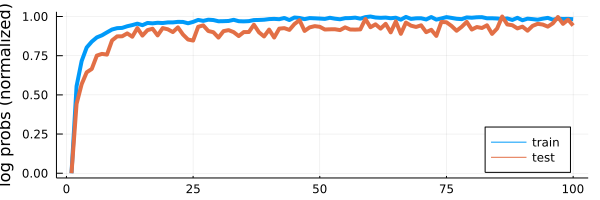

In [370]:
using Plots
plot(size=(600, 200), ylabel="log probs (normalized)", legend=:bottomright)
plot!((lp_hist[2:end] .- lp_hist[2]) / maximum(lp_hist  .- lp_hist[2]), lw=4, label="train")
plot!((test_ll_hist[2:end] .- test_ll_hist[2]) / maximum(test_ll_hist  .- test_ll_hist[2]), lw=4, label="test")

In [371]:
sum(z_hist[100] .== 0) / length(parents)

0.6193187035166652

# Save results

In [18]:
using JLD
JLD.@save "baseline.jld" zs model hypers z_hist ll_hist

In [19]:
results = JLD.load("baseline.jld")
z_hist, ll_hist, model, hypers, zs = 
    results["z_hist"], results["ll_hist"], results["model"], results["hypers"], results["zs"];

# Inspect results

In [456]:
function inspect(k, τ, parents, data, model::BinModel, prior, meta, word_distr; num_words=30, verbose=true)
    E, V, T, K = get_dims(model)
    
    cluster = data[(parents .== k) .& ([get_timebin(x.t) for x in data] .== τ)]
    words = Float64.(sum([x.w for x in cluster]))
    embassies = [sum([1 for x in cluster if x.e == e]) for e in 1:E]
           
    V0, n = word_distr, size(word_distr, 1)
    words ./= (sum(V0, dims=2)[:, 1] .+ 1/n)  # todo - normalize by embassy
    
    word_ids = sortperm(words, rev=true)[1:num_words]
    relevant_words = join(meta.vocab[word_ids, :word], " -- ")
    if verbose
        @info "cluster $k in timebin $τ:" relevant_words
    end
    
    return meta.vocab[word_ids, :word]
end

inspect(k, τ; verbose=true) = inspect(k, τ, parents, train_data, model, prior, meta, word_distr; verbose=verbose)


inspect(1, 1);

┌ Info: cluster 1 in timebin 1:
│   relevant_words = LTR RE -- USSR S T -- P PROCEDURE -- USSR ENVIRONMENTAL AGREEMENT -- BIO CAT -- DETAINEE -- ANGOLA S -- INTERNATIONAL OPERATIONS -- VIETNAMESE REFUGEE -- EQUIPMENT TRADE -- INTERNATIONAL AGREEMENT -- ILLICIT PAYMENTS -- INTERCHANGE -- IBEX -- ABROAD PROGRAM -- ACTION MEMORANDUM -- FAAS -- ESTIMATED NUMBER -- HIJACKED -- POTENTIAL EVACUEES -- FALCON -- GOVERNOR SCRANTON -- SMALL BUSINESS -- GIRAFFE -- NUMBER OF POTENTIAL -- FIELD BUDGET -- IMMIGRANT VISA -- UNDP GOVERNING COUNCIL -- LETTER OF JUNE -- AKA
└ @ Main In[456]:14


In [385]:
max_time

40.1

In [389]:
? get_timebin

search: get_timebin



No documentation found.

`get_timebin` is a `Function`.

```
# 1 method for generic function "get_timebin":
[1] get_timebin(t) in Main at In[5]:4
```


In [450]:
embassy_count = [sum(e_arr .== ei) for ei in 1:embassy_dim] / length(e_arr)
#event_probs = [sum(β[t, :] .* embassy_count) for t in 1:T]

t_grid = 0 : 0.01 : max_time - 0.1
total_intensity = (k, τ) -> [
   timebin(tp, model.intervals) == τ ? model.A[τ, k] / bin_size : -Inf for tp in t_grid
]

#594 (generic function with 1 method)

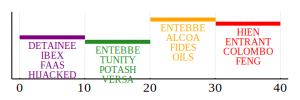

In [464]:
# Make cable intensity plot
theme(:default, label=nothing, tickfont=(8, "Times"), guidefont=(8, "Times"))
colorset = [:Purple, :ForestGreen, :Orange, :Red]

plt = plot(ylim=(0, maximum(model.A) / bin_size + 50), yticks=false)
for τ in 1:T
    series_color = colorset[τ]

    relevant_words = inspect(1, τ; verbose=false)
    relevant_words = filter(w -> (3 < length(w) < 9) && !occursin(" ", w), relevant_words)
    annotation = text(join(relevant_words[1:4], "\n"), 6, :Times, color=series_color)

    text_height = model.A[τ, 1] / bin_size - 150
    text_center = (τ - 0.5) * max_time / T

    plot!(t_grid, total_intensity(1, τ), c=series_color, lw=4)
    annotate!(text_center, text_height, annotation, valign=:top)
end

#plot!(t_grid, [model.A0 / max_time for tp in t_grid], lw=4, c=:Black)

plot!(plt, size=(300, 100))
savefig(plt, "embassy_results_baseline.pdf")
display(plt)

In [457]:
for t in 1:T
    inspect(1, t)
    println()
end

┌ Info: cluster 1 in timebin 1:
│   relevant_words = LTR RE -- USSR S T -- P PROCEDURE -- USSR ENVIRONMENTAL AGREEMENT -- BIO CAT -- DETAINEE -- ANGOLA S -- INTERNATIONAL OPERATIONS -- VIETNAMESE REFUGEE -- EQUIPMENT TRADE -- INTERNATIONAL AGREEMENT -- ILLICIT PAYMENTS -- INTERCHANGE -- IBEX -- ABROAD PROGRAM -- ACTION MEMORANDUM -- FAAS -- ESTIMATED NUMBER -- HIJACKED -- POTENTIAL EVACUEES -- FALCON -- GOVERNOR SCRANTON -- SMALL BUSINESS -- GIRAFFE -- NUMBER OF POTENTIAL -- FIELD BUDGET -- IMMIGRANT VISA -- UNDP GOVERNING COUNCIL -- LETTER OF JUNE -- AKA
└ @ Main In[456]:14


┌ Info: cluster 1 in timebin 2:
│   relevant_words = ENTEBBE -- TUNITY -- SOUTH ISSUES -- IRB -- POTASH -- HIJACKERS -- SASKATCHEWAN -- VERSA -- UMNO -- BORDEAUX AMCONSUL -- SINCERELY GERALD -- RAID -- AMCONSUL STRASBOURG -- AMCONSUL LYON AMCONSUL -- ESTIMATED NUMBER -- HOSTAGES -- BOIGNY -- FORCE BASE -- WEST BEIRUT -- RAJARATNAM -- STANTIAL -- UGANDAN -- POTENTIAL EVACUEES -- MORESBY -- QUID PRO -- FN -- BICENTENNIAL -- ADDICTS -- CORE GROUP -- UGANDA
└ @ Main In[456]:14


┌ Info: cluster 1 in timebin 3:
│   relevant_words = KONG S -- ENTEBBE -- POTENTIAL EVACUEES -- CURRENT HANDLING -- ONLY OFFICIALLY -- ESTIMATED NUMBER -- CORE GROUP -- ALCOA -- FIDES -- OILS -- GOVERNOR SCRANTON -- KIP -- VEGETABLE -- IRB -- NACC -- SASKATCHEWAN -- IMAM -- AEW -- EXECUTIVE DIRECTORS -- MELLE -- NFDM -- TUESDAY JULY -- ROBERTSON -- MACEACHEN -- BOIGNY -- SENTATIVE -- SIDON -- POTASH -- GOCAR -- FN
└ @ Main In[456]:14


┌ Info: cluster 1 in timebin 4:
│   relevant_words = SHAPE USCINCEUR -- IRB -- CORE GROUP -- PASSED ABOVE ADDEE -- ILLICIT PAYMENTS -- KOREAN ISSUE -- DE CUELLAR -- DEBT RELIEF -- HIEN -- WEST BEIRUT -- LENDING RATE -- PUERTO RICO -- MULTILATERAL AFFAIRS -- ENTRANT -- PURCHASING POWER -- SELF GOVERNING -- KOREAN AMBASSADOR -- GOVERNOR SCRANTON -- COLOMBO -- MORNING JULY -- UNQUOTE ROBINSON -- FENG -- PRODUCTION SHARING -- LA FLOR -- INDEXATION -- MUNICH AMCONSUL -- Q WELL -- NACC -- ENTEBBE -- TUESDAY JULY
└ @ Main In[456]:14
